### *Information Theory and Inference*

# **Auto-Encoding Variational Bayes**

## Model Explaination

### Intuition

<img src="model.jpg" alt="Alt text" width="700" > <br>

<img src="example.jpg" alt="Alt text" width="700" > <br>

<img src="example2.jpg" alt="Alt text" width="700" >

Variable x (high dimensional): generated from conditional distribution  &nbsp; $p_\theta(x|z)$ <br>
Unobserved continuous random variable z (much lower dimensional): generated from prior distribution &nbsp; $p_\theta(z)$ <br><br>
<img src="model3.jpg" alt="Alt text" width="700" > <br><br><br>

### Loss Function

Intractability: &nbsp; $p_\theta(z|x) = p_\theta(x|z)p_\theta(z)/p_\theta(x)$<br>
&nbsp;$p_\theta(x) = \int p_\theta(z)p_\theta(x|z)dz$<br>
Approximation: &nbsp; $p_\theta(z|x) \approx p_\phi(z|x)$

<img src="lossfunc.jpg" alt="Alt text" width="700" >

<img src="elbo.jpg" alt="Alt text" width="700" >

### Reparameterization Trick

<img src="repara.jpg" alt="Alt text" width="700" >

### Generic SGVB

<img src="KLD.jpg" alt="Alt text" width="700" >

<img src="kld2.jpg" alt="Alt text" width="700" >

# **1. Library Loading**

In [1]:
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.manifold import TSNE

from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
from torch.nn import functional as F




**Enable GPU for fast processing**

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **2. Vainilla Model**

For the first model, we create a simple vanilla model for the VAE. The structure is as follows:

1. Hidden Layer for imaging processing
2. Distinguished latent layer for the mu and the sigma value.
3. Reparametrization trick where the output is transformed using a gaussian distribution.
4. Latent layer for converting into hidden layer size
5. Hidden Layer for imaging conversion

In [3]:
class VAE_vanilla(nn.Module):
    """
    VARIATIONAL AUTO-ENCODER

    Structure:
        Encoding: In Layer -> Hidden Layer -> Latent Layer ->  Final Layer (mu)       
                                                                Final Layer (logvar)

        Gaussian Reparametrization: Mu       ->  Z
                                    Logvar
                                    Epsilon

        Decoding: Z -> Final Layer -> Latent Layer -> Hidden Layer -> Out Layer (Sigmoid)

    """

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=40, final_dim = 20, relu_factor = 0.2):
        super(VAE_vanilla, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(relu_factor)
            )
        
        # Mean and Logvar
        self.mean_layer = nn.Linear(latent_dim, final_dim)
        self.logvar_layer = nn.Linear(latent_dim, final_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(final_dim, latent_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        """
        Encode image 
        """
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization_gaussian(self, mean, var):
        """
        Perform reparametrization trick using a gaussian function
        """
        epsilon = torch.randn_like(var)    
        z = mean + var*epsilon
        return z

    def decode(self, x):
        """
        Decode image 
        """
        return self.decoder(x)

    def forward(self, x):
        """
        Perform forward propagation of image
        """
        mean, logvar = self.encode(x)
        z = self.reparameterization_gaussian(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

**Loss function**

In [4]:
def loss_function(x, x_hat, mean, log_var, beta):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - beta * 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

## 2.1 MNIST

**Data Loading**

In [5]:
random.seed(123)

# INIIILIZATION
path = '~/datasets'
batch_size = 64

# Create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# Download dataset
MNIST_traindataset_raw = MNIST(path, transform=transform, download=True)
MNIST_testdataset_raw = MNIST(path, transform=transform, download=True)

# Create train and test set
MNIST_traindataset = DataLoader(dataset=MNIST_traindataset_raw, batch_size=batch_size, shuffle = False)
MNIST_testdataset = DataLoader(dataset=MNIST_testdataset_raw, batch_size=batch_size, shuffle=False)

**Data plotting**

In [13]:
def data_plotting(dataset, number_samples = 25):
    """
    Plot a given number of samples from a image dataset

    Args: 
        name_dataset -> dataset to be used -> str
        number_samples -> number of samples to be drawn (root must be int) -> int
    
    """

    # Check if dataset has labels
    for val in dataset:
        break

    if len(val) == 2:
        img = val[0]
    
    else: 
        img = val
  
    # Create subplots
    fig, axis = plt.subplots(int(np.sqrt(number_samples)), int(np.sqrt(number_samples)), figsize= (5,5))

    # Flatten for better iteration
    axis = axis.flatten()

    for i in range(number_samples):
        axis[i].imshow(img[i].squeeze(), cmap = "gray"), axis[i].axis("off")
    
    return "Images generated successfully!"

'Images generated successfully!'

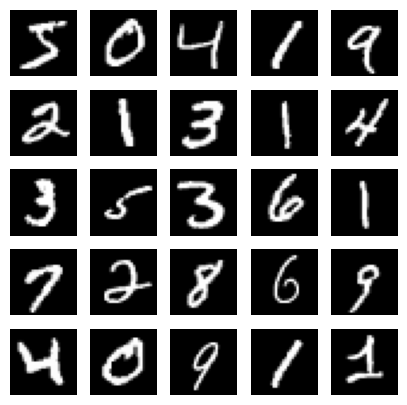

In [18]:
# Plot samples
data_plotting(MNIST_traindataset, 25)

**Model training**

In [7]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in MNIST_traindataset:
    break

# AUTO-ENCODER PARAMETERS
INP_DIM = img[0].squeeze().shape[0]*img[0].squeeze().shape[1]
HID_DIM = 400
LAT_DIM = 40
FIN_DIM = 20
RELU_T = 0.2

# TRAINING PARAMETERS
model_vmnist = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM,RELU_T )
optimizer = torch.optim.Adam(model_vmnist.parameters(), lr=1e-3)
epochs = 50

In [12]:
def train_model(model, dataset, epochs, batch_size, optimizer, input_dim, beta):
    """
    Train a Variational Auto-Encoder from scratch using PyTorch

    Args: 
        model -> VAE model -> class
        dataset -> training set to be used -> tensor
        epochs -> number of epochs for training -> int
        batch_size -> batch sizes of training dataset -> int
        optimizer -> model optimizer 
        input_dim -> flatten dimension to the desire value -> int
        verbose -> show loss at each epoch -> [0,1]
    
    Return:
        overall_loss -> loss 
        model -> trained model

    """

    # Initialize model 
    model.train()
    print("Starting model training...")

    total_loss =[]
    # Star iteration 
    for epoch in range(epochs):
        
        # Reset loss
        overall_loss = 0
        # Start iteration in batches
        for batch_idx, (x, _) in enumerate(dataset):

            # Flatten image
            x = x.view(len(x),input_dim)

            # Run model 
            optimizer.zero_grad()  # Set gradients to zero for avoiding gradient propagation
            x_hat, mean, log_var = model(x)  # Generate images alongside with parameters from reparametrization trick
            loss = loss_function(x, x_hat, mean,log_var, beta) # Compute loss
            
            # Extraxt loss and sum
            overall_loss += loss.item()
            
            # Backpropagate model 
            loss.backward()
            optimizer.step()
        
        # Display training metrics at each epoch
        total_loss.append(overall_loss/(batch_idx*batch_size))
    
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    
    print("Model training successfully")
        
    return total_loss, model

In [9]:
# change the hyperparameter beta
beta_values = [0.25, 1, 4, 16]

# Initialize lists to store results
loss_list = []
model_list = []

# Iterate over beta values and train the model
for beta in beta_values:
    # Initialize model and optimizer for each value of beta
    model_vmnist = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM,RELU_T )
    optimizer = torch.optim.Adam(model_vmnist.parameters(), lr=1e-3)
    
    # Run model for MNIST dataset
    loss_mnist_v, model_mnist_v = train_model(model_vmnist, MNIST_traindataset, epochs, batch_size, optimizer, INP_DIM, beta)
    
    # Store results in lists as tuples
    loss_list.append((beta, loss_mnist_v))
    model_list.append((beta, model_mnist_v))


Starting model training...
	Epoch 1 	Average Loss:  145.06999751267082
	Epoch 2 	Average Loss:  99.18289176835067
	Epoch 3 	Average Loss:  88.08213912003069
	Epoch 4 	Average Loss:  82.8682222600426
	Epoch 5 	Average Loss:  79.21787367406498
	Epoch 6 	Average Loss:  76.57102870228705
	Epoch 7 	Average Loss:  74.62923634141333
	Epoch 8 	Average Loss:  73.31838933075505
	Epoch 9 	Average Loss:  72.23912661459809
	Epoch 10 	Average Loss:  71.32540201453796
	Epoch 11 	Average Loss:  70.57788983633068
	Epoch 12 	Average Loss:  69.96015176600046
	Epoch 13 	Average Loss:  69.47005554248074
	Epoch 14 	Average Loss:  69.06134672785772
	Epoch 15 	Average Loss:  68.70458128612604
	Epoch 16 	Average Loss:  68.37684294660929
	Epoch 17 	Average Loss:  68.11137081948263
	Epoch 18 	Average Loss:  67.854014369187
	Epoch 19 	Average Loss:  67.6554511893648
	Epoch 20 	Average Loss:  67.46382678916386
	Epoch 21 	Average Loss:  67.2655034426564
	Epoch 22 	Average Loss:  67.0910821546231
	Epoch 23 	Average 

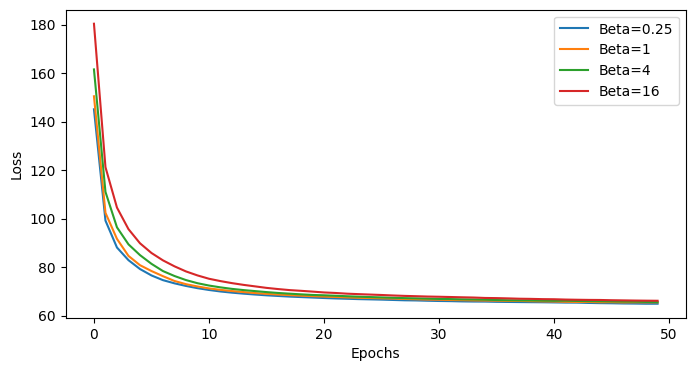

In [10]:
def plot_loss(loss_list):
    """
    Display loss evolution for multiple beta values

    Args: 
        loss_list: List of tuples containing beta value and corresponding loss values per epoch
    """

    # Create and display plot
    fig, axis = plt.subplots(1, 1, figsize=(8, 4))

    for beta, loss in loss_list:
        axis.plot(loss, label=f'Beta={beta}')

    axis.set_xlabel("Epochs")
    axis.set_ylabel("Loss")
    axis.legend()
    plt.show()


plot_loss(loss_list)

In [11]:
def encoding_VAE_multiple_betas(samples, model, betas):
    """
    Perform encoding of image samples using a VAE trained model for multiple beta values.

    Args:
        samples: Images to be encoded (list of tensors).
        model: VAE trained model.
        betas: List of beta values.

    Return:
        encoding: Encoded samples for each beta value.
    """

    encoding = {}
    for beta in betas:
        encoding[beta] = []
        for sample in samples:
            with torch.no_grad():
                mu, sigma = model.encode(sample)
                encoding[beta].append((mu, sigma))
    
    return encoding

def decoding_VAE_multiple_betas(encoded_samples, model, pixelw, pixelh):
    """
    Perform decoding of encoded image samples for multiple beta values.

    Args:
        encoded_samples: Encoded images (dictionary where keys are beta values and values are lists of encoded samples).
        model: VAE trained model.
        pixelw: Pixel width of the images.
        pixelh: Pixel height of the images.

    Return:
        decoding: Decoded samples for each beta value.
        reparametrization_val: Z values for each decoded image for each beta value.
    """

    decoding = {}
    reparametrization_val = {}
    
    for beta, samples in encoded_samples.items():
        decoding[beta] = []
        reparametrization_val[beta] = []
        for encoded_sample in samples:
            eps = torch.randn_like(encoded_sample[1])
            z = encoded_sample[0] + encoded_sample[1] * eps
            reparametrization_val[beta].append(z)
            decoding[beta].append(model.decode(z).reshape(pixelw, pixelh).to("cpu").detach().numpy())
    
    return decoding, reparametrization_val

# Extract samples
samples = []
idx = 0
for x, y in MNIST_testdataset_raw:
    if y == idx:
        samples.append(x.view(1, INP_DIM))
        idx += 1
    if idx == 10:
        break

# Encode samples for multiple beta values
encoded_samples = encoding_VAE_multiple_betas(samples, model_mnist_v, beta_values)

# Decode samples for multiple beta values
decoded_samples, z_values = decoding_VAE_multiple_betas(encoded_samples, model_mnist_v, 28, 28)


**Samples**

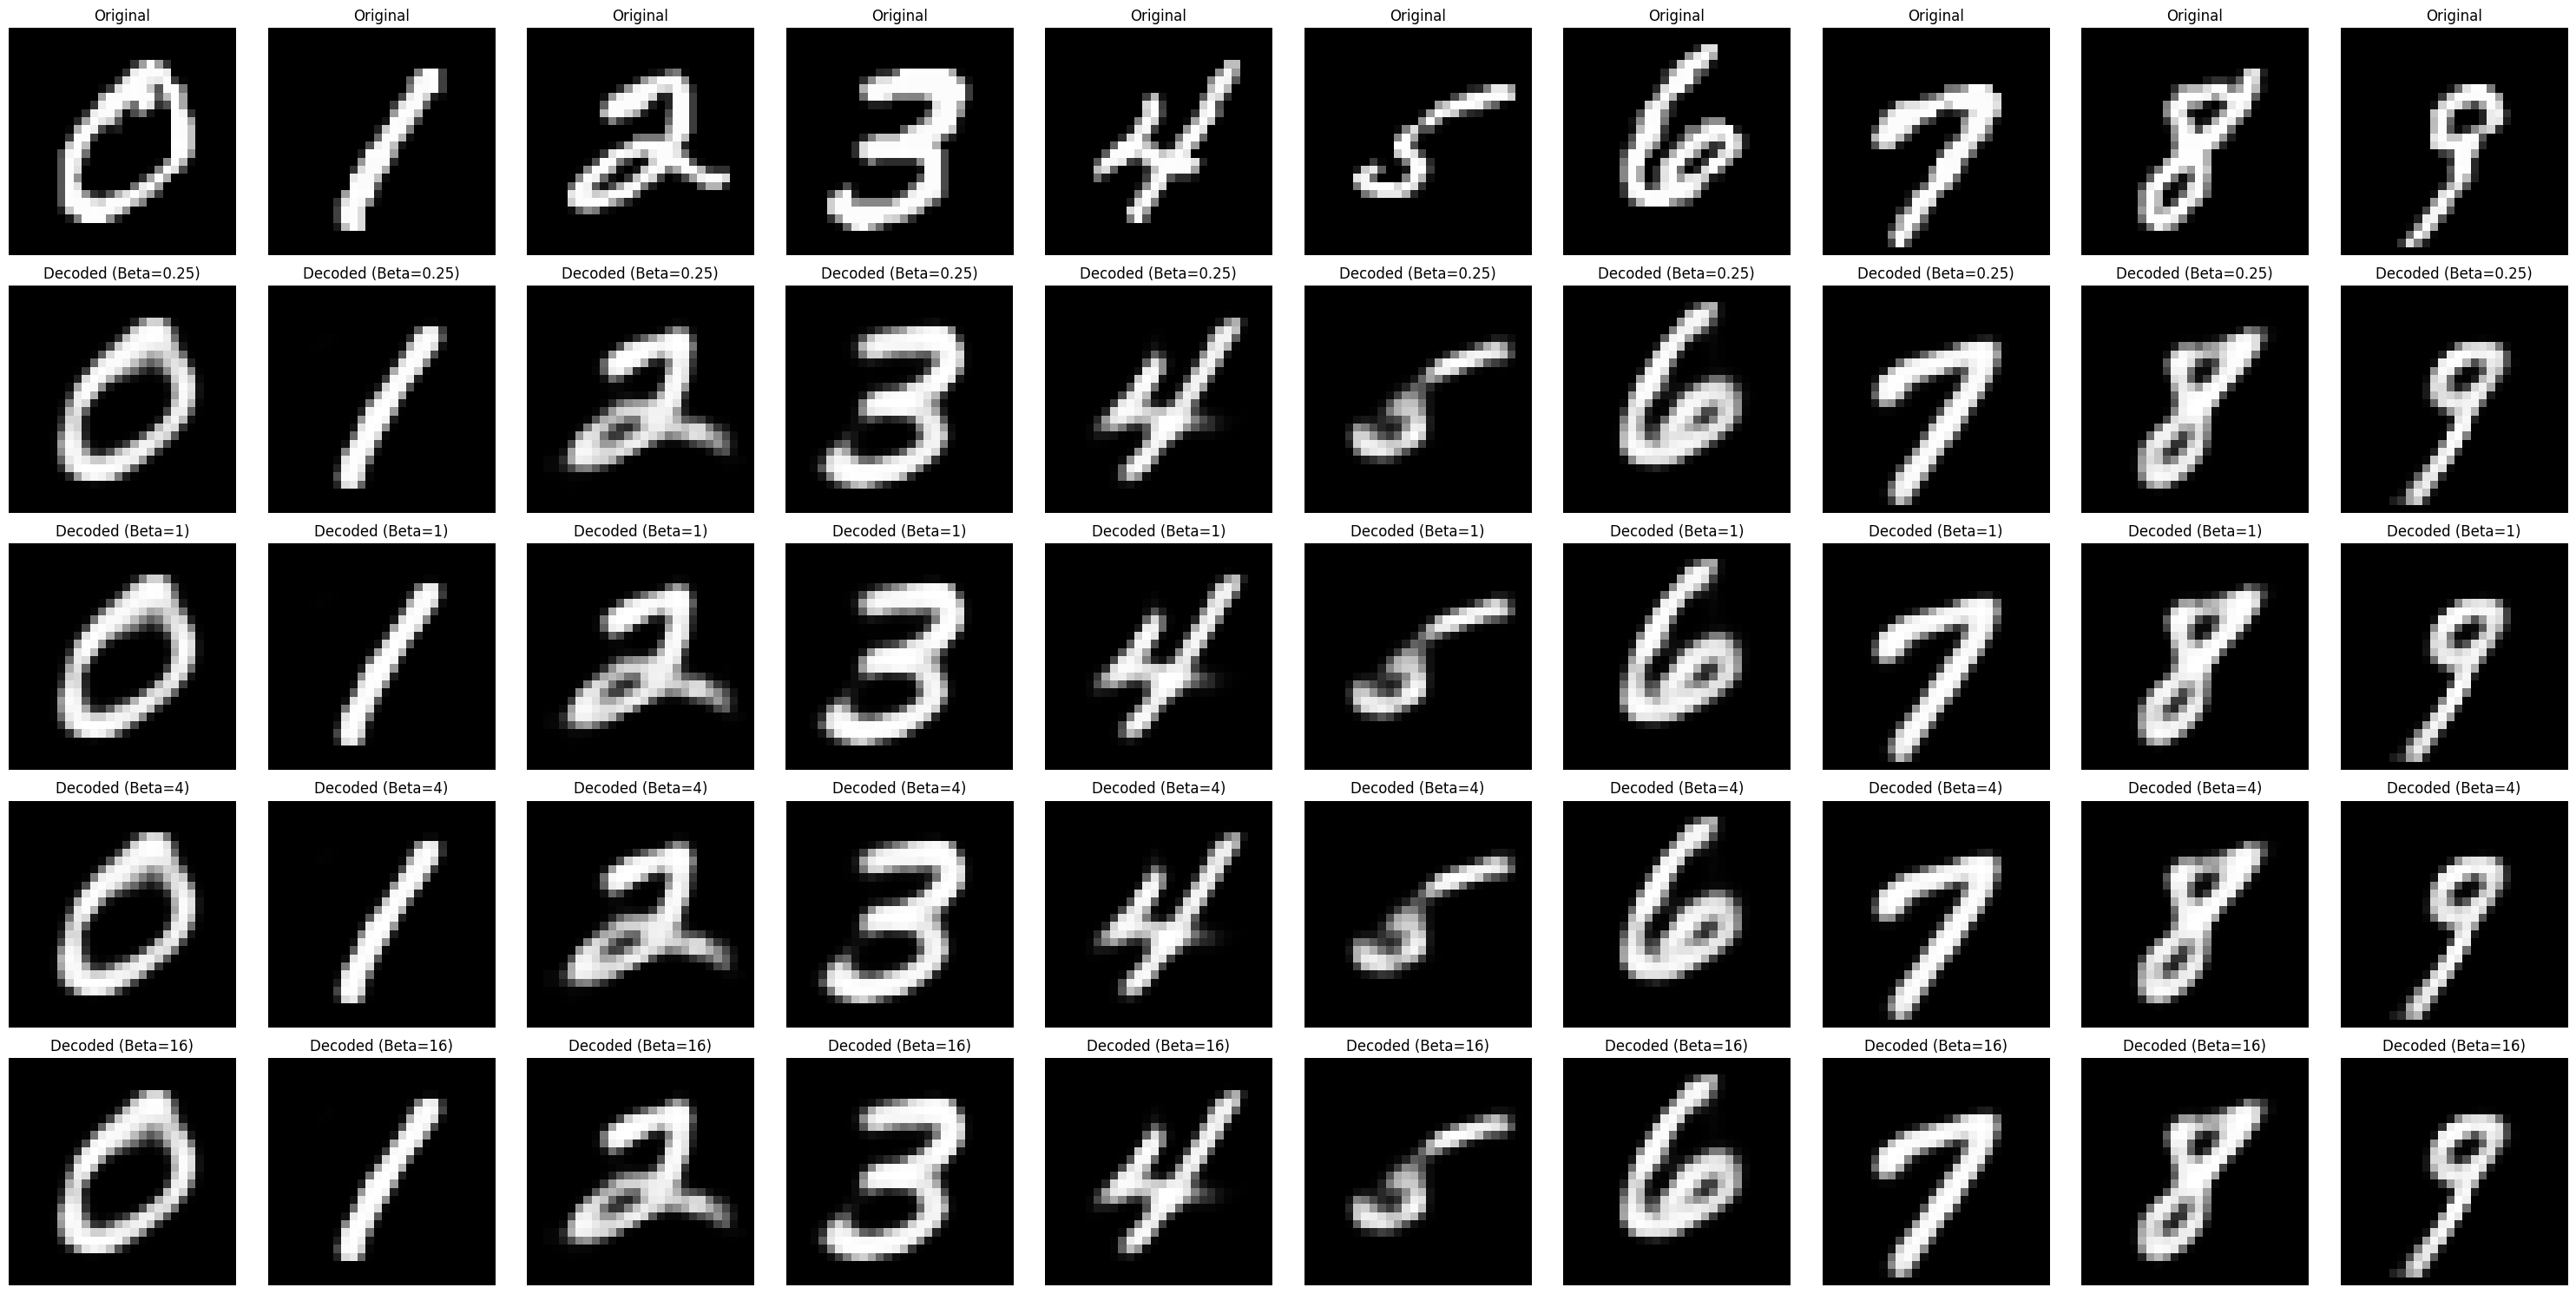

In [12]:
def plot_comparison(samples, decoded_samples):
    """
    Plot the comparison of original and decoded images for each beta value.

    Args: 
        samples: List of original image samples.
        decoded_samples: Dictionary containing decoded images for each beta value.

    """

    num_samples = len(samples)
    num_betas = len(decoded_samples)

    # Determine the number of rows and columns for subplots
    num_rows = num_betas + 1  # Additional row for original images
    num_cols = num_samples

    # Create subplots for each sample
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    # Plot original images
    for i in range(num_samples):
        axes[0, i].imshow(samples[i].view(28, 28), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

    # Plot decoded images for each beta value
    for j, beta in enumerate(decoded_samples):
        for i in range(num_samples):
            axes[j+1, i].imshow(decoded_samples[beta][i], cmap="gray")
            axes[j+1, i].set_title(f"Decoded (Beta={beta})")
            axes[j+1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_comparison(samples, decoded_samples)

## 2.2 Faces

**Data Loading**

In [13]:
# Loads Frey Face dataset
def get_FreyFace_data_loader(batchSize, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH):
    ff = scipy.io.loadmat('data/frey_rawface.mat')
    ff = ff["ff"].T.reshape((-1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
    ff = ff.astype('float32')/255.
    size = len(ff)
    ff = ff[:int(size/batchSize)*batchSize]
    ff_torch = torch.from_numpy(ff)

    testStart = int(0.9 * size)
    ff_train = ff_torch[:testStart]
    ff_test = ff_torch[testStart:]

    train_loader = torch.utils.data.DataLoader(ff_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(ff_test, batch_size=batch_size, shuffle=True)

    
    return (train_loader, test_loader)

In [14]:
IMG_CHANNELS = 1
IMG_HEIGHT = 28
IMG_WIDTH = 20

train_faces, test_faces = get_FreyFace_data_loader(64, IMG_CHANNELS , IMG_HEIGHT, IMG_WIDTH)

**Data plotting**

'Images generated successfully!'

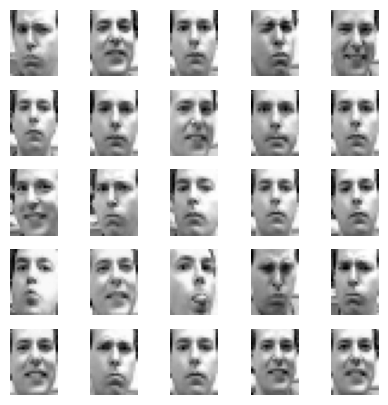

In [15]:
data_plotting(train_faces, 25)

**Model Training**

In [16]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img in train_faces:
    break

# AUTO-ENCODER PARAMETERS
INP_DIM = img[0].squeeze().shape[0]*img[0].squeeze().shape[1]
HID_DIM = 800
LAT_DIM = 100
FIN_DIM = 40
RELU_T = 0.2
beta = 1

In [17]:
def train_model_face(model, dataset, epochs, batch_size, optimizer, input_dim, beta):
    """
    Train a Variational Auto-Encoder from scratch using PyTorch

    Args: 
        model -> VAE model -> class
        dataset -> training set to be used -> tensor
        epochs -> number of epochs for training -> int
        batch_size -> batch sizes of training dataset -> int
        optimizer -> model optimizer 
        input_dim -> flatten dimension to the desire value -> int
        verbose -> show loss at each epoch -> [0,1]
    
    Return:
        overall_loss -> loss 
        model -> trained model

    """

    # Initialize model 
    model.train()
    print("Starting model training...")

    total_loss =[]
    # Star iteration 
    for epoch in range(epochs):
        
        # Reset loss
        overall_loss = 0
        # Start iteration in batches
        for batch_idx, x in enumerate(dataset):

            # Flatten image
            x = x.view(len(x),input_dim)

            # Run model 
            optimizer.zero_grad()  # Set gradients to zero for avoiding gradient propagation
            x_hat, mean, log_var = model(x)  # Generate images alongside with parameters from reparametrization trick
            loss = loss_function(x, x_hat, mean,log_var, beta) # Compute loss
            
            # Extraxt loss and sum
            overall_loss += loss.item()
            
            # Backpropagate model 
            loss.backward()
            optimizer.step()
        
        # Display training metrics at each epoch
        total_loss.append(overall_loss/(batch_idx*batch_size))
    
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    
    print("Model training successfully")
        
    return total_loss, model

In [18]:

model_vface = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM, RELU_T)
optimizer = torch.optim.Adam(model_vface.parameters(), lr=1e-3)

# Run model for face dataset
loss_face_v, model_face_v = train_model_face(model_vface, train_faces, epochs, batch_size, optimizer, INP_DIM, beta)

Starting model training...
	Epoch 1 	Average Loss:  368.7177383987992
	Epoch 2 	Average Loss:  359.6780242919922
	Epoch 3 	Average Loss:  359.27384101019965
	Epoch 4 	Average Loss:  358.44619129322194
	Epoch 5 	Average Loss:  356.2391662597656
	Epoch 6 	Average Loss:  355.0021746600116
	Epoch 7 	Average Loss:  353.6893457483362
	Epoch 8 	Average Loss:  352.98499269838686
	Epoch 9 	Average Loss:  352.5069342719184
	Epoch 10 	Average Loss:  352.01939674660014
	Epoch 11 	Average Loss:  351.6184811062283
	Epoch 12 	Average Loss:  351.3774905734592
	Epoch 13 	Average Loss:  351.1520900019893
	Epoch 14 	Average Loss:  350.85389822500724
	Epoch 15 	Average Loss:  350.66923127350987
	Epoch 16 	Average Loss:  350.4111763283058
	Epoch 17 	Average Loss:  350.14937958893955
	Epoch 18 	Average Loss:  349.96020168728296
	Epoch 19 	Average Loss:  349.7357793737341
	Epoch 20 	Average Loss:  349.7504843252677
	Epoch 21 	Average Loss:  349.488858823423
	Epoch 22 	Average Loss:  349.3468509250217
	Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


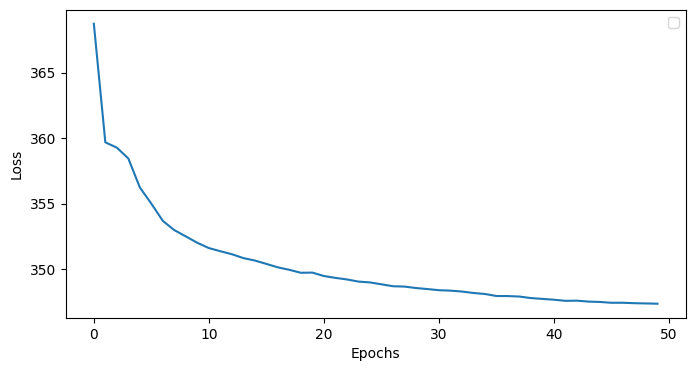

In [19]:
def plot_loss(loss):
    """
    Display loss evolution for multiple beta values

    Args: 
        loss_list: List of tuples containing beta value and corresponding loss values per epoch
    """

    # Create and display plot
    fig, axis = plt.subplots(1, 1, figsize=(8, 4))
    axis.plot(loss)

    axis.set_xlabel("Epochs")
    axis.set_ylabel("Loss")
    axis.legend()
    plt.show()

plot_loss(loss_face_v)

In [20]:
samples = []
idx = 1
latent = []
for x in test_faces:
      for i in range(9):
         samples.append(x[i])
      break

In [21]:
def encoding_VAE(samples, model):
    """
    Perform encoding of an image type sample using a VAE trained model

    Args:
        samples -> images to be encoded -> list
        model -> VAE trained model
    
    Return:
        encoding -> samples encoded 
    """

    # Create list for saving encoding
    encoding = []
    for i in range(len(samples)):

        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            mu, sigma = model.encode(samples[i].view(1,560))
            encoding.append((mu, sigma))
    
    return encoding

def decoding_VAE(encoded_samples, model, pixelw, pixelh):
    """
    Perform reparametrization and decoding of an encoded image type. Aditionally, store the z values
    for later analysis

    Args:
        encoded_samples -> encoded images (mu, sigma)
        model -> VAE trained model

    Return:
        decoding -> samples decoded 
        reparametrization_val -> z values for each img generated
    """

    # Create list for saving decoding 
    decoding = []
    reparametrization_val = []
    for i in range(len(encoded_samples)):

        # Generate epsilon values
        eps = torch.randn_like(encoded_samples[i][1])

        # Perform reparametrization trick
        z = encoded_samples[i][0] + encoded_samples[i][1]*eps

        reparametrization_val.append(z)
        
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(model.decode(z).reshape(pixelw,pixelh).to("cpu").detach().numpy())
    
    return decoding, reparametrization_val


# Encode random images
encoded_face_v = encoding_VAE(samples, model_face_v)

# Decode random images
decoded_face_v, z_face_v = decoding_VAE(encoded_face_v, model_face_v, 28, 20)

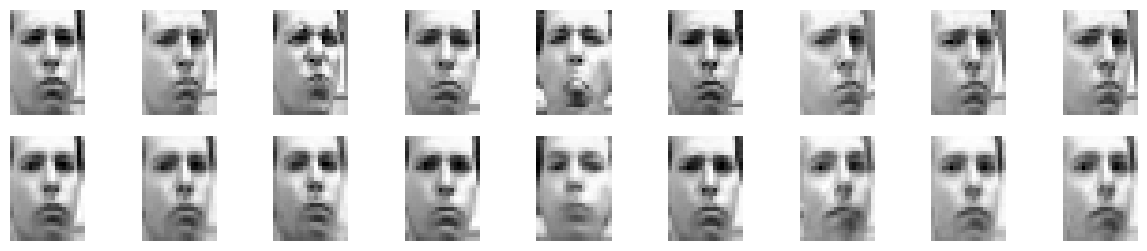

In [22]:
fig, axis = plt.subplots(2,9, figsize= (15,3))
for i in range(len(samples)):
    axis[0][i].imshow(samples[i].squeeze(), cmap = 'gray')
    axis[1][i].imshow(decoded_face_v[i], cmap = 'gray')
    axis[0][i].axis("off")
    axis[1][i].axis("off")

## 2.3 CIFAR10

**Load data**

In [14]:
# Define a custom transform to convert RGB to grayscale
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)  # Convert to grayscale with one channel
])

# Load CIFAR-10 dataset with the custom transform
CIFAR_traindataset_raw = CIFAR10(root=path, train=True, transform=transform, download=True)
CIFAR__testdataset_raw = CIFAR10(root=path, train=False, transform=transform, download=True)

# create train and test dataloaders
batch_size = 64
CIFAR_traindataset = DataLoader(dataset=CIFAR_traindataset_raw, batch_size=batch_size, shuffle=True)
CIFAR__testdataset = DataLoader(dataset=CIFAR__testdataset_raw, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


**Data plotting**

'Images generated successfully!'

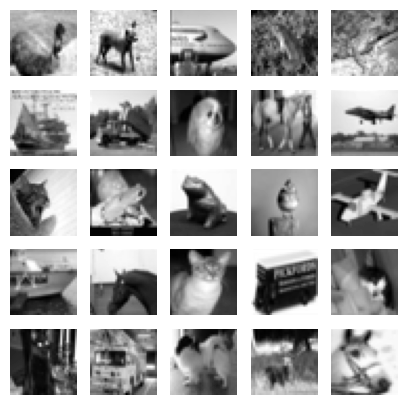

In [15]:
data_plotting(CIFAR_traindataset, 25)

**Model Training**

In [16]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in CIFAR_traindataset:
    break

# AUTO-ENCODER PARAMETERS
INP_DIM = img[0].squeeze().shape[0]*img[0].squeeze().shape[1]
HID_DIM = 800
LAT_DIM = 100
FIN_DIM = 40
RELU_T = 0.2
beta = 1

In [26]:
model_vcifar = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM, RELU_T)
optimizer = torch.optim.Adam(model_vcifar.parameters(), lr=1e-3)

# Run model for face dataset
loss_cifar_v, model_cifar_v = train_model(model_vcifar, CIFAR_traindataset, epochs, batch_size, optimizer, INP_DIM, 1)

Starting model training...
	Epoch 1 	Average Loss:  638.6945868185632
	Epoch 2 	Average Loss:  623.2766632001928
	Epoch 3 	Average Loss:  616.8768273425621
	Epoch 4 	Average Loss:  613.3725179362083
	Epoch 5 	Average Loss:  611.535097285819
	Epoch 6 	Average Loss:  609.7474616682026
	Epoch 7 	Average Loss:  608.228540300865
	Epoch 8 	Average Loss:  606.8111344458351
	Epoch 9 	Average Loss:  605.776601598449
	Epoch 10 	Average Loss:  605.0094516573429
	Epoch 11 	Average Loss:  604.2453458348859
	Epoch 12 	Average Loss:  603.3416024768551
	Epoch 13 	Average Loss:  602.7063378445165
	Epoch 14 	Average Loss:  601.977280874411
	Epoch 15 	Average Loss:  601.4746773068945
	Epoch 16 	Average Loss:  601.057065467981
	Epoch 17 	Average Loss:  600.6709563271185
	Epoch 18 	Average Loss:  600.3992127090044
	Epoch 19 	Average Loss:  600.063071647771
	Epoch 20 	Average Loss:  599.8317415674578
	Epoch 21 	Average Loss:  599.6312221473371
	Epoch 22 	Average Loss:  599.4319409359432
	Epoch 23 	Average L

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


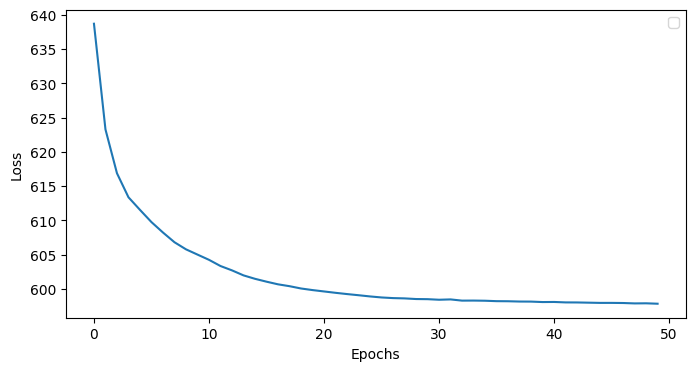

In [27]:
plot_loss(loss_cifar_v)

In [28]:
samples = []
idx = 0
for x, y in CIFAR__testdataset_raw:
    if y == idx:
        samples.append(x.view(1, INP_DIM))
        idx += 1
    if idx == 10:
        break

In [29]:
def encoding_VAE(samples, model):
    """
    Perform encoding of an image type sample using a VAE trained model

    Args:
        samples -> images to be encoded -> list
        model -> VAE trained model
    
    Return:
        encoding -> samples encoded 
    """

    # Create list for saving encoding
    encoding = []
    for i in range(len(samples)):

        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            mu, sigma = model.encode(samples[i].view(1,1024))
            encoding.append((mu, sigma))
    
    return encoding

def decoding_VAE(encoded_samples, model, pixelw, pixelh):
    """
    Perform reparametrization and decoding of an encoded image type. Aditionally, store the z values
    for later analysis

    Args:
        encoded_samples -> encoded images (mu, sigma)
        model -> VAE trained model

    Return:
        decoding -> samples decoded 
        reparametrization_val -> z values for each img generated
    """

    # Create list for saving decoding 
    decoding = []
    reparametrization_val = []
    for i in range(len(encoded_samples)):

        # Generate epsilon values
        eps = torch.randn_like(encoded_samples[i][1])

        # Perform reparametrization trick
        z = encoded_samples[i][0] + encoded_samples[i][1]*eps

        reparametrization_val.append(z)
        
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(model.decode(z).reshape(pixelw,pixelh).to("cpu").detach().numpy())
    
    return decoding, reparametrization_val

In [30]:
# Encode random images
encoded_cifar_v = encoding_VAE(samples, model_cifar_v)

# Decode random images
decoded_cifar_v, z_cifar_v = decoding_VAE(encoded_cifar_v, model_cifar_v, 32, 32)

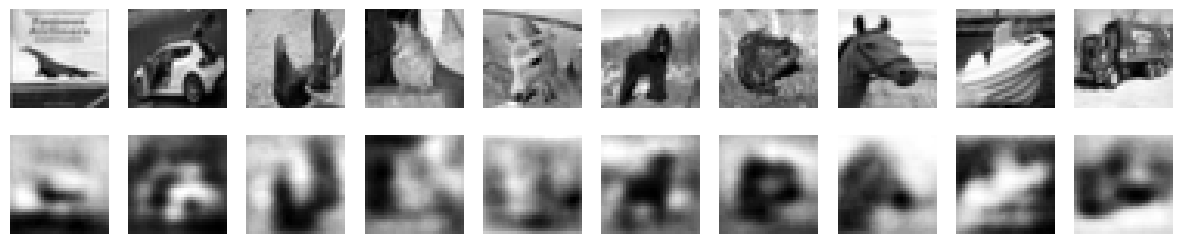

In [31]:
fig, axis = plt.subplots(2,10, figsize= (15,3))
for i in range(len(samples)):
    axis[0][i].imshow(samples[i].reshape(32,32), cmap = 'gray')
    axis[1][i].imshow(decoded_cifar_v[i], cmap = 'gray')
    axis[0][i].axis("off")
    axis[1][i].axis("off")

# **3. Convolutional Model**

In [2]:
class VAE_Conv(nn.Module):
    
    def __init__(self, convFeatures=(32, 64), hiddenNum=50, channelsin=1):
        
        super(VAE_Conv, self).__init__()

        self.convFeatures = convFeatures
        
        # ENCODER
        # convolute -> maxpool -> convolute -> maxpool -> fully connected x2
        self.encodeConv1 = nn.Conv2d(in_channels=channelsin, 
                                     out_channels=self.convFeatures[0], 
                                     kernel_size=3,
                                     padding=1)
        self.encodeMaxPool = nn.MaxPool2d(kernel_size=2, 
                                           return_indices=True)
        self.encodeConv2 = nn.Conv2d(in_channels=self.convFeatures[0], 
                                     out_channels=self.convFeatures[1], 
                                     kernel_size=3,
                                     padding=1)
        self.totalPooledSize = self.convFeatures[1] * (IMG_WIDTH // 4) * (IMG_HEIGHT // 4)

        # Mean and Variance
        self.encodeFC = nn.Linear(in_features=self.totalPooledSize, 
                                  out_features=hiddenNum)
        self.encodeMeanFC = nn.Linear(in_features=hiddenNum, 
                                      out_features=LATENT_DIM)
        self.encodeVarianceFC = nn.Linear(in_features=hiddenNum, 
                                          out_features=LATENT_DIM)

        # DECODER
        # fully connected x2 -> unpool -> convolute -> unpool -> convolute x2
        self.decodeFC1 = nn.Linear(in_features=LATENT_DIM, 
                                   out_features=hiddenNum)
        self.decodeFC2 = nn.Linear(in_features=hiddenNum, 
                                   out_features=self.totalPooledSize)
        self.decodeUnPool1 = nn.MaxUnpool2d(kernel_size=2)
        self.decodeUnConv1 = nn.ConvTranspose2d(in_channels=self.convFeatures[1], 
                                                out_channels=self.convFeatures[0], 
                                                kernel_size=3,
                                                padding=1)
        self.decodeUnPool2 = nn.MaxUnpool2d(kernel_size=2)
        self.decodeUnConv2 = nn.ConvTranspose2d(in_channels=self.convFeatures[0], 
                                                out_channels=channelsin, # 1, 
                                                kernel_size=3,
                                                padding=1)
        self.decodeFinalConv = nn.Conv2d(in_channels= channelsin, # 1, 
                                         out_channels=channelsin, 
                                         kernel_size=3,
                                         padding=1)
        self.normalDist = torch.distributions.Normal(torch.zeros(LATENT_DIM), torch.ones(LATENT_DIM))

     
    def encode(self, x):
        x = nn.LeakyReLU(0.2, inplace=True)(self.encodeConv1(x))
        x, self.indices1 = self.encodeMaxPool(x)
        x = nn.LeakyReLU(0.2, inplace=True)(self.encodeConv2(x))
        x, self.indices2 = self.encodeMaxPool(x)
        x = x.view(-1, self.totalPooledSize)
        x = nn.LeakyReLU(0.2, inplace=True)(self.encodeFC(x))
        mean = nn.Flatten()(self.encodeMeanFC(x))
        varianceLog = self.encodeVarianceFC(x)
        return mean, varianceLog

    def reparameterization_gaussian(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        x = nn.LeakyReLU(0.2, inplace=True)(self.decodeFC1(x))
        x = nn.LeakyReLU(0.2, inplace=True)(self.decodeFC2(x))
        x = x.view(-1, self.convFeatures[1], IMG_WIDTH // 4, IMG_HEIGHT // 4)
        x = self.decodeUnPool1(x, indices=self.indices2)
        x = nn.LeakyReLU(0.2, inplace=True)(self.decodeUnConv1(x))
        x = self.decodeUnPool2(x, indices=self.indices1)
        x = nn.LeakyReLU(0.2, inplace=True)(self.decodeUnConv2(x))
        x = nn.LeakyReLU(0.2, inplace=True)(self.decodeFinalConv(x))
        return torch.sigmoid(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization_gaussian(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [3]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

## 3.1 MNIST

In [34]:
LATENT_DIM = 10
IMG_WIDTH = 28
IMG_HEIGHT = 28

In [4]:
def train_model(model, dataset, epochs, batch_size, optimizer,input_dim):
    """
    Train a Variational Auto-Encoder from scratch using PyTorch

    Args: 
        model -> VAE model -> class
        dataset -> training set to be used -> tensor
        epochs -> number of epochs for training -> int
        batch_size -> batch sizes of training dataset -> int
        optimizer -> model optimizer 
        input_dim -> flatten dimension to the desire value -> int
        verbose -> show loss at each epoch -> [0,1]
    
    Return:
        overall_loss -> loss 
        model -> trained model

    """

    # Initialize model 
    model.train()
    print("Starting model training...")

    total_loss =[]
    # Star iteration 
    for epoch in range(epochs):
        
        # Reset loss
        overall_loss = 0
        # Start iteration in batches
        for batch_idx, (x, _) in enumerate(dataset):

            # Flatten image
            #x = x.view(28,28,1)

            # Run model 
            optimizer.zero_grad()  # Set gradients to zero for avoiding gradient propagation
            x_hat, mean, log_var = model(x)  # Generate images alongside with parameters from reparametrization trick
            loss = loss_function(x, x_hat, mean, log_var) # Compute loss
            
            # Extraxt loss and sum
            overall_loss += loss.item()
            
            # Backpropagate model 
            loss.backward()
            optimizer.step()
        
        # Display training metrics at each epoch
        total_loss.append(overall_loss/(batch_idx*batch_size))
        
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    
    print("Model training successfully")
        
    return total_loss, model

In [36]:
# TRAINING PARAMETERS
model_cmnist = VAE_Conv(convFeatures = (32, 64), hiddenNum = 10, channelsin = 1)
optimizer = torch.optim.Adam(model_cmnist.parameters(), lr=1e-3)
epochs = 10

In [37]:
# Run model for MNIST dataset
loss_mnist_c, model_mnist_c = train_model(model_cmnist, MNIST_traindataset, epochs, batch_size, optimizer, INP_DIM)

Starting model training...
	Epoch 1 	Average Loss:  121.58063710232045
	Epoch 2 	Average Loss:  64.61222817778206
	Epoch 3 	Average Loss:  60.0861827093102
	Epoch 4 	Average Loss:  58.13336155788621
	Epoch 5 	Average Loss:  57.155402249689416
	Epoch 6 	Average Loss:  56.26870381895735
	Epoch 7 	Average Loss:  55.65309955063599
	Epoch 8 	Average Loss:  55.12919137521131
	Epoch 9 	Average Loss:  54.732389124378706
	Epoch 10 	Average Loss:  54.379582123161
Model training successfully


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


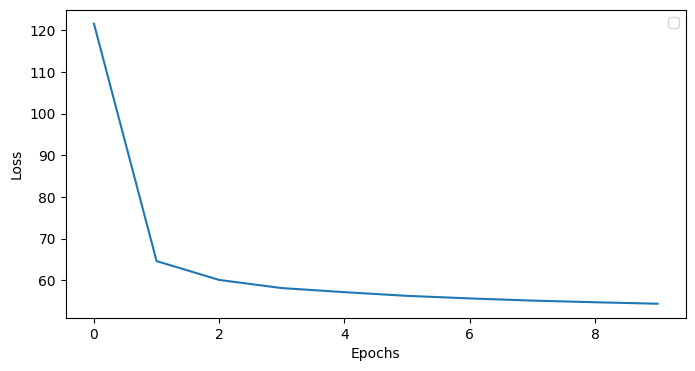

In [38]:
plot_loss(loss_mnist_c)

In [39]:
# Extract samples from the dataset (one for each number)
samples = []
idx = 0
for x, y in MNIST_testdataset_raw:
    if y == idx:
        samples.append(x) # .view(1,INP_DIM))
        idx+=1

    if idx ==10:
        break

In [44]:
def encoding_VAE(samples, model):
    """
    Perform encoding of an image type sample using a VAE trained model

    Args:
        samples -> images to be encoded -> list
        model -> VAE trained model
    
    Return:
        encoding -> samples encoded 
    """

    # Create list for saving encoding
    encoding = []
    for i in range(len(samples)):

        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            a,b,c = samples[i].shape
            mu, sigma = model.encode(samples[i].view(1,a,b,c))
            encoding.append((mu, sigma))
    
    return encoding

def decoding_VAE(encoded_samples, model, pixelw, pixelh):
    """
    Perform reparametrization and decoding of an encoded image type. Aditionally, store the z values
    for later analysis

    Args:
        encoded_samples -> encoded images (mu, sigma)
        model -> VAE trained model

    Return:
        decoding -> samples decoded 
        reparametrization_val -> z values for each img generated
    """

    # Create list for saving decoding 
    decoding = []
    reparametrization_val = []
    for i in range(len(encoded_samples)):

        # Generate epsilon values
        eps = torch.randn_like(encoded_samples[i][1])

        # Perform reparametrization trick
        z = encoded_samples[i][0] + encoded_samples[i][1]*eps
        reparametrization_val.append(z)
        
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(model.decode(z).reshape(pixelw,pixelh).to("cpu").detach().numpy())
        #decoding.append(model.decode(z).to("cpu").detach().numpy())
    
    return decoding, reparametrization_val


# Encode random images
encoded_nmist_c = encoding_VAE(samples, model_mnist_c)

# Decode random images
decoded_mnist_c, z_mnist_c = decoding_VAE(encoded_nmist_c, model_mnist_c, 28, 28)

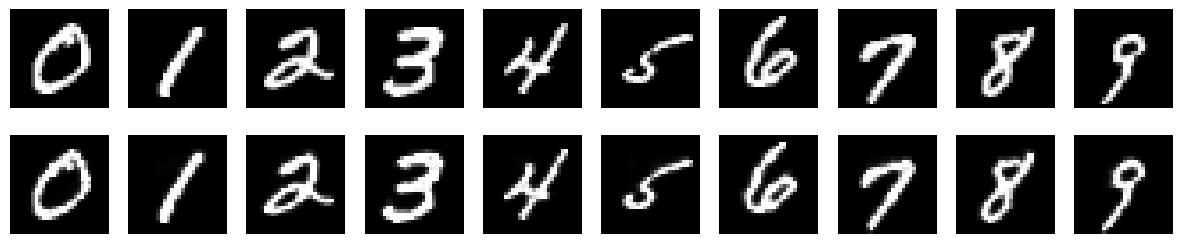

In [45]:
def plot_samples(samples, model):
    # Create list for saving encoding
    encoding = []
    decoding = []
    reparametrization_val = []

    fig, axis = plt.subplots(2,10, figsize= (15,3))
    for i in range(len(samples)):
        
        ## ENCODE
        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            a,b,c = samples[i].shape 
            mu, sigma = model.encode(samples[i].view(1,a,b,c))  
            encoding.append((mu, sigma))

        ## DECODE
        # Generate epsilon values
        eps = torch.randn_like(sigma)
        # Perform reparametrization trick
        z = mu + sigma*eps
        reparametrization_val.append(z)
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(model.decode(z).reshape(28,28).to("cpu").detach().numpy())

        # plot results
        axis[0][i].imshow(samples[i].view(28,28), cmap = "gray")
        axis[1][i].imshow(model.decode(z).reshape(28,28).to("cpu").detach().numpy(), cmap = "gray")

        # check if equal
        # x1 = samples[i].view(28,28)
        # x2 = model.decode(z).reshape(28,28).to("cpu").detach().numpy()
        # print(np.array_equal(x1,x2))
        
        axis[0][i].axis("off")
        axis[1][i].axis("off")

plot_samples(samples, model_mnist_c )

## 3.2 CIFAR10 GRAY

In [46]:
LATENT_DIM = 10
IMG_WIDTH = 32
IMG_HEIGHT = 32

In [47]:
# TRAINING PARAMETERS
model_ccifar = VAE_Conv(convFeatures = (32, 64), hiddenNum = 10, channelsin = 1)
optimizer = torch.optim.Adam(model_ccifar.parameters(), lr=1e-3)
epochs = 10

In [48]:
# Run model for MNIST dataset
loss_cifar_c, model_cifar_c = train_model(model_ccifar, CIFAR_traindataset, epochs, batch_size, optimizer, INP_DIM)

Starting model training...
	Epoch 1 	Average Loss:  608.0878532497587
	Epoch 2 	Average Loss:  590.7719442291846
	Epoch 3 	Average Loss:  589.1312195097744
	Epoch 4 	Average Loss:  588.1043777954258
	Epoch 5 	Average Loss:  587.3775130111949
	Epoch 6 	Average Loss:  587.0770176925366
	Epoch 7 	Average Loss:  586.850454274274
	Epoch 8 	Average Loss:  586.6888621155645
	Epoch 9 	Average Loss:  586.5557018480289
	Epoch 10 	Average Loss:  586.4373453606717
Model training successfully


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


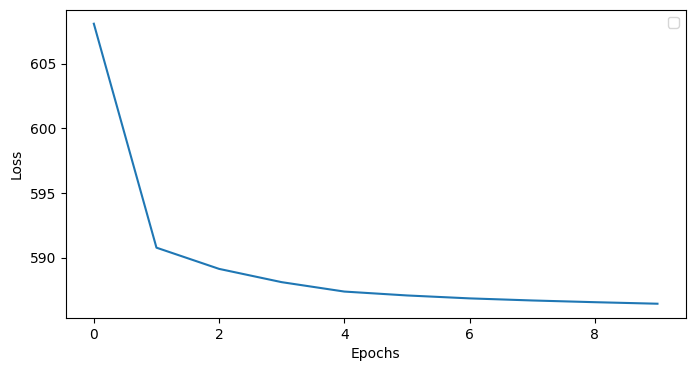

In [49]:
plot_loss(loss_cifar_c)

In [50]:
# Extract samples from the dataset (one for each number)
samples = []
idx = 0
for x, y in CIFAR_traindataset_raw:
    if y == idx:
        samples.append(x) # .view(1,INP_DIM))
        idx+=1

    if idx ==10:
        break

In [51]:
# Encode random images
encoded_cifar_c = encoding_VAE(samples, model_cifar_c)

# Decode random images
decoded_cifar_c, z_cifar_c = decoding_VAE(encoded_cifar_c, model_cifar_c, 32, 32)

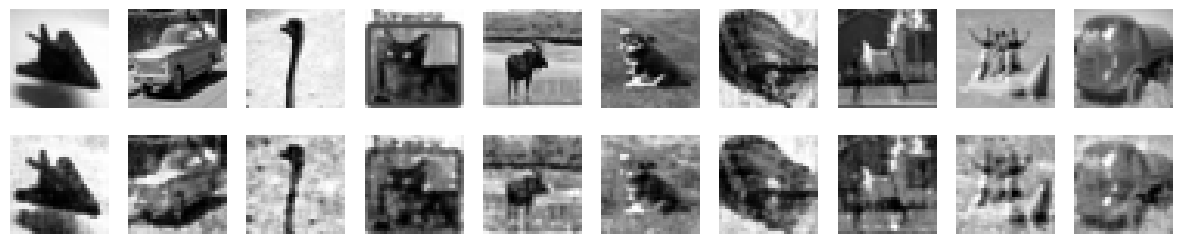

In [56]:
def plot_samples(samples, model):
    # Create list for saving encoding
    encoding = []
    decoding = []
    reparametrization_val = []

    fig, axis = plt.subplots(2,10, figsize= (15,3))
    for i in range(len(samples)):
        
        ## ENCODE
        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            a,b,c = samples[i].shape 
            mu, sigma = model.encode(samples[i].view(1,a,b,c))  
            encoding.append((mu, sigma))

        ## DECODE
        # Generate epsilon values
        eps = torch.randn_like(sigma)
        # Perform reparametrization trick
        z = mu + sigma*eps
        reparametrization_val.append(z)
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(model.decode(z).reshape(32,32).to("cpu").detach().numpy())

        # plot results
        axis[0][i].imshow(samples[i].view(32,32), cmap = "gray")
        axis[1][i].imshow(model.decode(z).reshape(32,32).to("cpu").detach().numpy(), cmap = "gray")

        # check if equal
        # x1 = samples[i].view(28,28)
        # x2 = model.decode(z).reshape(28,28).to("cpu").detach().numpy()
        # print(np.array_equal(x1,x2))
        
        axis[0][i].axis("off")
        axis[1][i].axis("off")

plot_samples(samples, model_cifar_c )

## 3.3 CIFAR10 

**Load data**

In [6]:
# Define a custom transform to convert RGB to grayscale
transform = transforms.Compose([
     transforms.ToTensor()
    #transforms.Grayscale(num_output_channels=1)  # Convert to grayscale with one channel
])

# Load CIFAR-10 dataset with the custom transform
CIFAR_traindataset_col_raw = CIFAR10(root=path, train=True, transform=transform, download=True)
CIFAR__testdataset_col_raw = CIFAR10(root=path, train=False, transform=transform, download=True)

# create train and test dataloaders
batch_size = 64
random.seed(123)
CIFAR_traindataset_col = DataLoader(dataset=CIFAR_traindataset_col_raw, batch_size=batch_size, shuffle=True)
CIFAR__testdataset_col = DataLoader(dataset=CIFAR__testdataset_col_raw, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def data_plotting_col(dataset, number_samples=25):
    """
    Plot a given number of samples from the CIFAR image dataset

    Args: 
        dataset: CIFAR dataset to be used (list of samples)
        number_samples: number of samples to be drawn (should be a perfect square), default is 25 (int)
    
    """

    # Create subplots
    fig, axis = plt.subplots(int(np.sqrt(number_samples)), int(np.sqrt(number_samples)), figsize=(5, 5))

    # Flatten for better iteration
    axis = axis.flatten()

    for i in range(number_samples):
        img = np.asarray(dataset[i][0])  # Convert the image to a numpy array
        img = np.moveaxis(img, 0, -1)  # Move the channel dimension to the last axis
        axis[i].imshow(img)
        axis[i].axis("off")
    
    plt.show()
    return "Images generated successfully!"


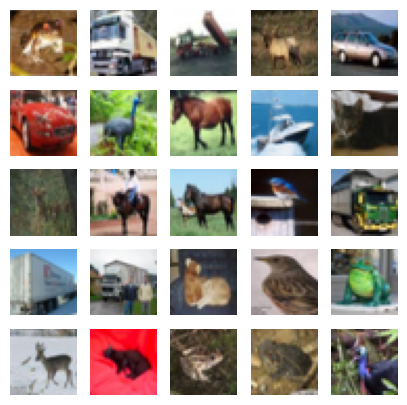

'Images generated successfully!'

In [8]:
# Plot samples
data_plotting_col(CIFAR_traindataset_col_raw, 25)

In [9]:
# change the dimension of latent variables
LATENT_DIM_list = [2, 5, 10, 15, 20]

IMG_WIDTH = 32
IMG_HEIGHT = 32

epochs = 15

In [17]:
# Initialize lists to store results
loss_list = []
model_list = []

# Iterate over LATENT_DIM values and train the model
for dim in LATENT_DIM_list:
    LATENT_DIM = dim
    model_ccifar2 = VAE_Conv(convFeatures = (32, 64), hiddenNum = 10, channelsin = 3)
    optimizer = torch.optim.Adam(model_ccifar2.parameters(), lr=1e-3)
 
    # Run model for cifar dataset
    loss_cifar_c2, model_cifar_c2 = train_model(model_ccifar2, CIFAR_traindataset_col, epochs, batch_size, optimizer, INP_DIM)

    # Store results in lists as tuples
    loss_list.append((dim, loss_cifar_c2))
    model_list.append((dim, model_cifar_c2))

Starting model training...
	Epoch 1 	Average Loss:  1837.7506802958196
	Epoch 2 	Average Loss:  1771.6198094327685
	Epoch 3 	Average Loss:  1761.0272767754432
	Epoch 4 	Average Loss:  1757.7942024651013
	Epoch 5 	Average Loss:  1755.584189245246
	Epoch 6 	Average Loss:  1753.567704126258
	Epoch 7 	Average Loss:  1751.652069599772
	Epoch 8 	Average Loss:  1750.6104814478133
	Epoch 9 	Average Loss:  1749.3094059630332
	Epoch 10 	Average Loss:  1747.5493997532335
	Epoch 11 	Average Loss:  1746.5217944351568
	Epoch 12 	Average Loss:  1746.1381334605198
	Epoch 13 	Average Loss:  1745.8661846009472
	Epoch 14 	Average Loss:  1745.103895746639
	Epoch 15 	Average Loss:  1744.8246733485967
Model training successfully
Starting model training...
	Epoch 1 	Average Loss:  1831.093739606049
	Epoch 2 	Average Loss:  1764.428827771762
	Epoch 3 	Average Loss:  1750.8239285008704
	Epoch 4 	Average Loss:  1744.8869101784446
	Epoch 5 	Average Loss:  1741.3504211972831
	Epoch 6 	Average Loss:  1739.44069328

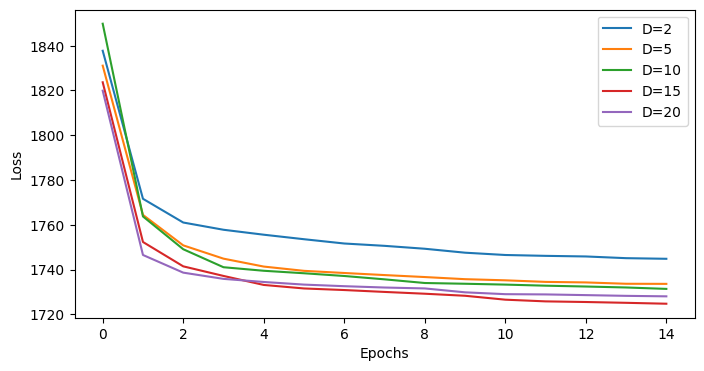

In [18]:
def plot_loss(loss_list):
    """
    Display loss evolution for multiple dimension values

    Args: 
        loss_list: List of tuples containing dimension value and corresponding loss values per epoch
    """

    # Create and display plot
    fig, axis = plt.subplots(1, 1, figsize=(8, 4))

    for dim, loss in loss_list:
        axis.plot(loss, label=f'D={dim}')

    axis.set_xlabel("Epochs")
    axis.set_ylabel("Loss")
    axis.legend()
    plt.show()


plot_loss(loss_list)

In [68]:
# Extract samples from the dataset (one for each number)
samples = []
idx = 0
for x, y in CIFAR_traindataset_col_raw:
    if y == idx:
        samples.append(x) # .view(1,INP_DIM))
        idx+=1

    if idx ==10:
        break

In [42]:
def encoding_VAE(samples, model):
    """
    Perform encoding of an image type sample using a VAE trained model

    Args:
        samples -> images to be encoded -> list
        model -> VAE trained model
    
    Return:
        encoding -> samples encoded 
    """
        # Create list for saving encoding
    encoding = []

    for i in range(len(samples)):

        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            a,b,c = samples[i].shape
            mu, sigma = model.encode(samples[i].view(1,a,b,c))
            encoding.append((mu, sigma))

    return encoding

def decoding_VAE(encoded_samples, model, pixelw, pixelh):
    """
    Perform reparametrization and decoding of an encoded image type. Aditionally, store the z values
    for later analysis

    Args:
        encoded_samples -> encoded images (mu, sigma)
        model -> VAE trained model

    Return:
        decoding -> samples decoded 
        reparametrization_val -> z values for each img generated
    """

    # Create list for saving decoding 

    decoding = []
    reparametrization_val = []
            
    for i in range(len(encoded_samples)):
        # Generate epsilon values
        eps = torch.randn_like(encoded_samples[i][1])

        # Perform reparametrization trick
        z = encoded_samples[i][0] + encoded_samples[i][1]*eps
        reparametrization_val.append(z)
        
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(model.decode(z).reshape(3, pixelw,pixelh).to("cpu").detach().numpy())
        #decoding.append(model.decode(z).to("cpu").detach().numpy())


                
    return decoding, reparametrization_val

In [54]:
for i in range(len(LATENT_DIM_list)):
    encoded_cifar_c2 = {}
    decoded_cifar_c2 = {}
    z_cifar_c2 = {}
    
    # Encode random images
    encoded_cifar_c2[i] = encoding_VAE(samples, model_list[i][1])

    # Decode random images
    decoded_cifar_c2[i], z_cifar_c2[i] = decoding_VAE(encoded_cifar_c2[i], model_list[i][1], 32, 32)

In [94]:
def plot_samples(samples, model_list):
    
    fig, axes = plt.subplots(6, 10, figsize=(120, 90))
    
    # plot results
    
    for i, model_tuple in enumerate(model_list):
        model = model_tuple[1]
        for j, sample in enumerate(samples):
            # Avoid gradient computation 
            # Add caption indicating the value of d=i
        
            with torch.no_grad():
                # Compute mu and sigma values
                mu, sigma = model.encode(sample.view(1, *sample.shape))  
            # Generate epsilon values
            eps = torch.randn_like(sigma)
            # Perform reparametrization trick
            z = mu + sigma * eps
            # Obtain new image, reshape it, send it back to CPU and convert it back into numpy array
            decoded_img = model.decode(z).to("cpu").detach().numpy()[0]

            # Plot original and decoded images
            axes[0, j].imshow(np.moveaxis(sample.numpy(), 0, -1))
            axes[0, j].axis("off")
            # Add caption indicating the value of d=i
            if i == 0 and j == 0:
                axes[i][j].set_title('original', fontsize=200)
            
            axes[i+1, j ].imshow(np.moveaxis(decoded_img, 0, -1))
            axes[i+1, j ].axis("off")

            if i == 1 and j == 0:
                axes[i][j].set_title('D=2', fontsize=200)
            
            if i == 2 and j == 0:
                axes[i][j].set_title('D=5', fontsize=200)

            if i == 3 and j == 0:
                axes[i][j].set_title('D=10', fontsize=200)
            
            if i == 4 and j == 0:
                axes[i][j].set_title('D=15', fontsize=200)
            
            if i == 5 and j == 0:
                axes[i][j].set_title('D=20', fontsize=200)
            
             # Set titles for the last row
            if j == 0:
                axes[i+1, j].set_title('D=20', fontsize=200)

       
    plt.show()

# Example usage
plot_samples(samples, model_list)